In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
files=os.listdir("./data/results")

In [3]:
grid = [s for s in files if "grid" in s] # files with results for grid search
random = [s for s in files if "random" in s] 
group = [s for s in files if "group" in s] 

In [4]:
grid_df=pd.DataFrame([])
for file in grid:
    df = pd.read_csv("./data/results/"+file)
    
    df['iter_num']=1
    df.loc[df['experiment_name']!='default params', 
           'iter_num'] = range(1, df.loc[df['experiment_name']!='default params'].shape[0]+1)
    
    grid_df = pd.concat([grid_df, df], sort=False)


group_df=pd.DataFrame([])
for file in group:
    df = pd.read_csv("./data/results/"+file)
    
    df['iter_num'] = range(1, df.shape[0]+1)
    
    group_df = pd.concat([group_df, df], sort=False)
    
random_df=pd.DataFrame([])
for file in random:
    df = pd.read_csv("./data/results/"+file)
    
    df['iter_num'] = range(1, df.shape[0]+1)
    
    random_df = pd.concat([random_df, df], sort=False)

In [5]:
df = pd.concat([grid_df, group_df, random_df], sort=False)

In [6]:
grid_time = 1940.05

random_time = [2073.10, 1991.44, 1941.67,
               1830.35, 1770.31, 1805.24,
               1883.62, 1863.26, 1877.53
              ]


groups_time = [
    [810.24, 765.14, 742.56, 744.10, 749.14, 
     676.46, 702.35, 749.01, 715.88, 677.28],
    [515.27, 518.78, 519.46, 520.49, 520.53, 
     491.02, 495.51, 497.50, 498.53, 489.28],
    [521.28, 521.50, 522.18, 525.42, 526.47, 
     495.62, 499.08, 499.29, 500.98, 491.89]
]#first, second and third groups

default_time = 2.02

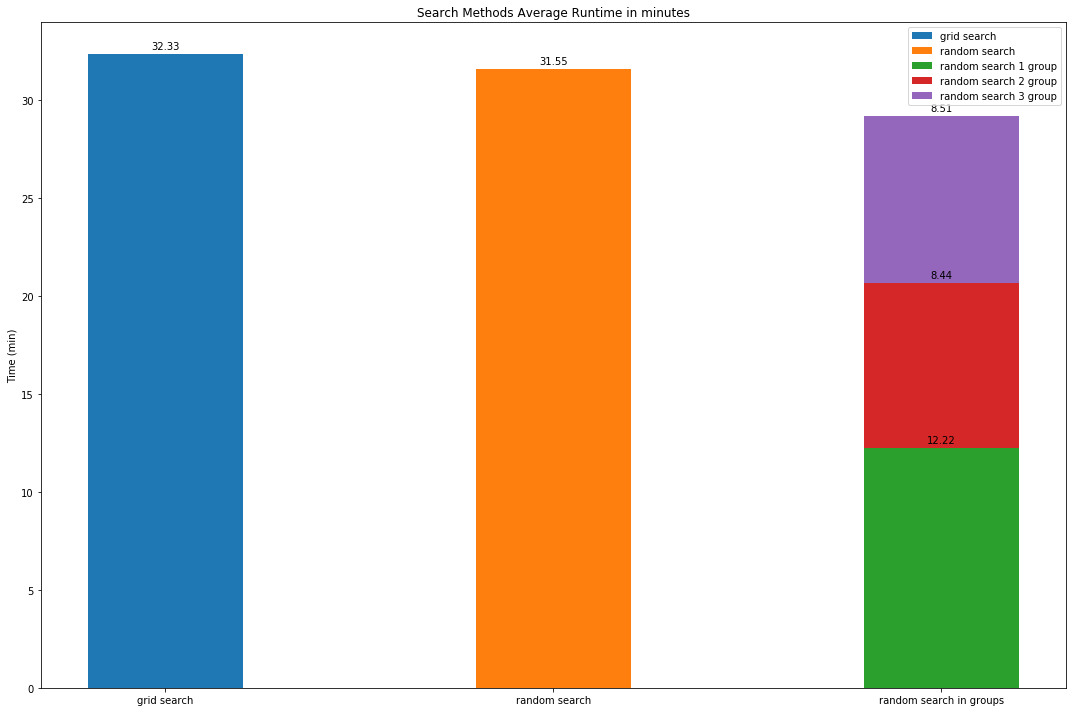

In [7]:
def autolabel(rects, add=0):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()+add
        ax.annotate('{}'.format(round(height-add,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')
        
x = [0,0.5,1]  
width = 0.2  

fig, ax = plt.subplots(figsize=(15,10))

labels=['grid search','random search', 'random search in groups']

rects1 = ax.bar(0, grid_time/60, width, label='grid search')
rects2 = ax.bar(0.5, np.mean(random_time)/60, width, label='random search')


groups_time_mean = np.mean(groups_time, axis =1)/60
rects3_1 = ax.bar(1, groups_time_mean[0], width, label='random search 1 group')
rects3_2 = ax.bar(1, groups_time_mean[1], width,
             bottom=groups_time_mean[0], label='random search 2 group')
rects3_3 = ax.bar(1, groups_time_mean[2], width,
             bottom=groups_time_mean[0] + groups_time_mean[1], 
                  label='random search 3 group')


ax.set_ylabel('Time (min)')
ax.set_title('Search Methods Average Runtime in minutes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='best')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3_1)
autolabel(rects3_2, groups_time_mean[0])
autolabel(rects3_3, groups_time_mean[0]+groups_time_mean[1])
fig.tight_layout()

plt.savefig("graphs/1_time_exec.jpg")
plt.show()

In [8]:
top5=df.loc[:,['experiment_name','params','mean_test_score']].sort_values(by='mean_test_score',ascending=False)[:5]

In [9]:
top5 #random search is in top5 than sometimes it may be better than serch in groups

,experiment_name,params,mean_test_score
718,random search for 3 group,"{'colsample_bytree': 0.7726166520388937, 'subs...",0.669707
611,random search for 3 group,"{'colsample_bytree': 0.6377829940262529, 'subs...",0.668893
494,random search for 3 group,"{'colsample_bytree': 0.8561761903119284, 'subs...",0.668684
489,random search for 3 group,"{'colsample_bytree': 0.5791399443148867, 'subs...",0.667752
234,random search,"{'alpha': 0.8252577014252843, 'colsample_bytre...",0.667675


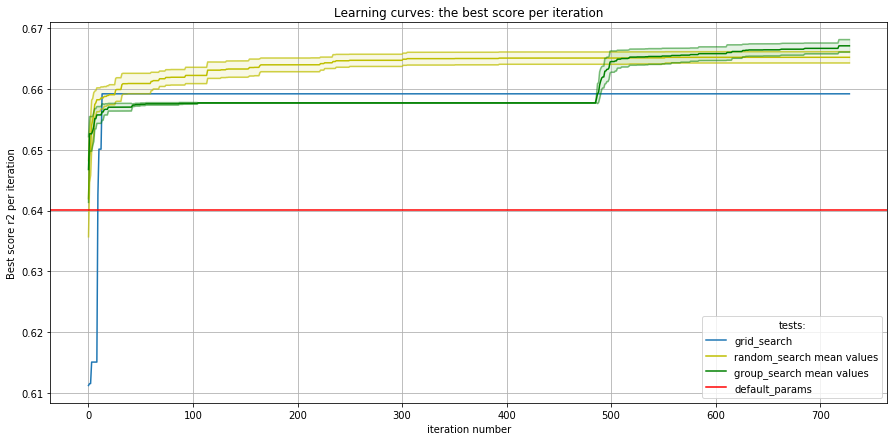

In [10]:
#comparison
# confidence intervals theory get from: 
# https://medium.com/ml-ai-study-group/confidence-interval-confidence-level-be58d250dd40


## GRID_SEARCH
#get best scores per itration for grid_search performance:
grid_perf=grid_df.loc[grid_df['experiment_name']!='default params', 'mean_test_score'].cummax()


## RANDOM_SEARCH
#get best scores per itration for each random_search performance:
random_mean=pd.DataFrame([])
for i in random_df.run_number.unique():
    tmp=pd.DataFrame(random_df.loc[random_df.run_number==i, "mean_test_score"].copy().cummax())
    tmp["iter_num"]=random_df.loc[random_df.run_number==i, "iter_num"]
    random_mean=pd.concat([random_mean, tmp], sort=False)
    
#get mean and confidence interval value for random_search performance on iteration:    

z = 1.96 # for 95% conf interval (coefficient)
# z = 1.64 # for 90% conf interval

n=random_mean.shape[0]/random_mean.iter_num.max() # now n=9, because 4 runs were made for random search
random_std=random_mean.groupby(by="iter_num")['mean_test_score'].std() #std
random_std=(random_std*z)/np.sqrt(n) #confidence interval value 
random_mean=random_mean.groupby(by="iter_num")['mean_test_score'].mean() #mean


## GROUP_SEARCH
#get best scores per itration for each group_search performance (same computations):
group_mean=pd.DataFrame([])
for i in group_df.run_number.unique():
    tmp=pd.DataFrame(group_df.loc[group_df.run_number==i, "mean_test_score"].cummax())
    tmp["iter_num"]=group_df.loc[group_df.run_number==i, "iter_num"]
    group_mean=pd.concat([group_mean, tmp], sort=False)

n=group_mean.shape[0]/group_mean.iter_num.max() # now n=10
group_std=group_mean.groupby(by="iter_num")['mean_test_score'].std()
group_std=(group_std*z)/np.sqrt(n) 
group_mean=group_mean.groupby(by="iter_num")['mean_test_score'].mean()

## DEFAULT performance
default_perf=grid_df.loc[grid_df['experiment_name']=='default params', 'mean_test_score']


## PLOT
plt.figure(figsize=(15,7))
plt.grid()
x=list(range(0, grid_perf.shape[0]))

#grid plot:
plt.plot(x, grid_perf, label="grid_search")

#conf for random:
plt.plot(x, random_mean, color="y", label="random_search mean values")
lower_random=random_mean - random_std
upper_random=random_mean + random_std
plt.plot(x, lower_random, alpha=0.7, color="y")
plt.plot(x, upper_random, alpha=0.7, color="y")
plt.fill_between(x, lower_random, upper_random, alpha=0.1, color="y") 

#conf for group:
plt.plot(x, group_mean, color="green", label="group_search mean values")
lower_group=group_mean - group_std
upper_group=group_mean + group_std
plt.plot(x, lower_group, alpha=0.5, color="green")
plt.plot(x, upper_group, alpha=0.5, color="green")
plt.fill_between(x, lower_group, upper_group, alpha=0.1, color="green")

#line for default values
plt.axhline(default_perf.values, label="default_params", color='r')

plt.legend(title='tests:')
plt.title("Learning curves: the best score per iteration")
plt.ylabel("Best score r2 per iteration")
plt.xlabel("iteration number")
plt.savefig("graphs/2_scores.jpg")
plt.show()

In [11]:
#print("green last lower values: ", lower_group.iloc[-11:-1])
#print("yellow last upper values: ", upper_random.iloc[0:10])
print("difference: ", ((lower_group.iloc[-1:].values-upper_random.iloc[-1:].values) > 0).all())
print("difference is less than zero than intervals don't intersect in last point")

difference:  False
difference is less than zero than intervals don't intersect in last point


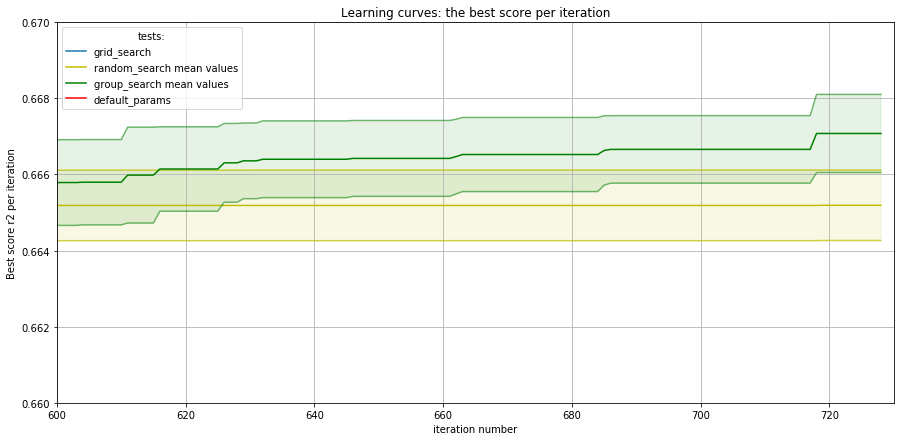

In [12]:
#comparison
# confidence intervals theory get from: 
# https://medium.com/ml-ai-study-group/confidence-interval-confidence-level-be58d250dd40

## PLOT
plt.figure(figsize=(15,7))
plt.grid()
x=list(range(0, grid_perf.shape[0]))

#grid plot:
plt.plot(x, grid_perf, label="grid_search")

#conf for random:
plt.plot(x, random_mean, color="y", label="random_search mean values")
plt.plot(x, lower_random, alpha=0.7, color="y")
plt.plot(x, upper_random, alpha=0.7, color="y")
plt.fill_between(x, lower_random, upper_random, alpha=0.1, color="y") 

#conf for group:
plt.plot(x, group_mean, color="green", label="group_search mean values")
plt.plot(x, lower_group, alpha=0.5, color="green")
plt.plot(x, upper_group, alpha=0.5, color="green")
plt.fill_between(x, lower_group, upper_group, alpha=0.1, color="green")

#line for default values
plt.axhline(default_perf.values, label="default_params", color='r')

plt.legend(title='tests:')
plt.title("Learning curves: the best score per iteration")
plt.ylabel("Best score r2 per iteration")
plt.xlabel("iteration number")
plt.xlim(600,730)
plt.ylim(0.66, 0.67)
plt.savefig("graphs/2_scores_scaled.jpg")
plt.show()

In [13]:
df.loc[df.experiment_name=="grid search", "run_number"]=1

In [14]:
df.loc[df.experiment_name == 'default params','mean_test_score']

729    0.640144
Name: mean_test_score, dtype: float64

In [15]:
best_scores=df.groupby(by=['experiment_name', 'run_number'])['mean_test_score'].max().reset_index()
#print("best scores:")
#print(best_scores)

best=pd.merge(df, best_scores, how='inner', on=['experiment_name','run_number','mean_test_score']).loc[:,['experiment_name','mean_test_score', 'params', 'iter_num','run_number']]
#best step and params

In [16]:
print("MEAN:")
print(best_scores.groupby(by='experiment_name')['mean_test_score'].mean())
print("STD:")
print(best_scores.groupby(by='experiment_name')['mean_test_score'].std())

MEAN:
experiment_name
grid search                  0.659186
random search                0.665191
random search for 1 group    0.657690
random search for 2 group    0.657690
random search for 3 group    0.667078
Name: mean_test_score, dtype: float64
STD:
experiment_name
grid search                       NaN
random search                0.001492
random search for 1 group    0.000000
random search for 2 group    0.000000
random search for 3 group    0.001657
Name: mean_test_score, dtype: float64


In [17]:
best_iter=best.groupby(by=['experiment_name', 'run_number'])['iter_num'].min().reset_index()

In [18]:
params=pd.merge(df, best_iter, how='inner', on=['experiment_name','iter_num','run_number'])

In [19]:
best_iter.loc[best_iter.experiment_name=="random search for 2 group", "iter_num"]-=(729/3)
best_iter.loc[best_iter.experiment_name=="random search for 3 group", "iter_num"]-=(2*729/3)

In [20]:
#cols=params.experiment_name.values
vals=params.loc[:, ["experiment_name", "params"]]
for i in vals.experiment_name.unique():
    print(i)
    tmp=(vals.loc[vals.experiment_name==i, 'params'])
    tmp=tmp.apply(lambda x: eval(x)).apply(pd.Series)
    print("MEAN:")
    print(tmp.mean())
    print("STD:")
    print(tmp.std())
    
    print("====")

grid search
MEAN:
alpha               0.250
colsample_bytree    0.625
lambda              0.250
max_depth           5.000
min_child_weight    5.000
subsample           0.750
dtype: float64
STD:
alpha              NaN
colsample_bytree   NaN
lambda             NaN
max_depth          NaN
min_child_weight   NaN
subsample          NaN
dtype: float64
====
random search for 1 group
MEAN:
max_depth           5.0
min_child_weight    9.0
dtype: float64
STD:
max_depth           0.0
min_child_weight    0.0
dtype: float64
====
random search for 2 group
MEAN:
alpha     0.460037
lambda    0.471978
dtype: float64
STD:
alpha     0.371950
lambda    0.264047
dtype: float64
====
random search for 3 group
MEAN:
colsample_bytree    0.691896
subsample           0.825079
dtype: float64
STD:
colsample_bytree    0.110971
subsample           0.037044
dtype: float64
====
random search
MEAN:
alpha               0.436345
colsample_bytree    0.659581
lambda              0.489646
max_depth           4.900000
min_chil

In [ ]:
# on which min step algo get best result 
import math
best_iter=best_iter.loc[best_iter['experiment_name']!='default params'].reset_index(drop=True)
x = np.arange(best_iter.shape[0])  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))

labels_prefix=best_iter.loc[:,'experiment_name']
labels_postfix=best_iter.loc[:,'run_number']
labels=np.sum((labels_prefix.values+" ", labels_postfix.values.astype(int).astype(str)), axis=0)+" run"

rects=[]
for row in range(best_iter.shape[0]):
    rects.append(ax.bar(row, best_iter.loc[row,'iter_num'], width, label=labels[row]))
    autolabel(rects[row])

ax.set_ylabel('Step num')
ax.set_title('Step number at which the optimum was reached')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)

fig.tight_layout()

plt.savefig("graphs/3_best_step.jpg")
plt.show()

In [ ]:
print("MEAN:")
print(best_iter.groupby(by="experiment_name")["iter_num"].mean())
print("STD: ")
print(best_iter.groupby(by="experiment_name")["iter_num"].std())

In [ ]:
#random search in groups has null values
df.loc[df.experiment_name=='random search for 1 group',
                  'param_alpha']=0
df.loc[df.experiment_name=='random search for 1 group',
                  'param_colsample_bytree']=1
df.loc[df.experiment_name=='random search for 1 group',
                  'param_lambda']=1
df.loc[df.experiment_name=='random search for 1 group',
                  'param_subsample']=1

In [ ]:
df.loc[df.experiment_name=='random search for 2 group',
                  'param_max_depth']=5
df.loc[df.experiment_name=='random search for 2 group',
                  'param_colsample_bytree']=1
df.loc[df.experiment_name=='random search for 2 group',
                  'param_min_child_weight']=9
df.loc[df.experiment_name=='random search for 2 group',
                  'param_subsample']=1

In [ ]:
df.loc[df.experiment_name=='random search for 3 group',
                  'param_max_depth']=5
df.loc[df.experiment_name=='random search for 3 group',
                  'param_min_child_weight']=9


In [ ]:
max_iter=df.loc[(df.experiment_name=='random search for 2 group'),"iter_num"].max()
lost_params=df.loc[(df.experiment_name=='random search for 2 group')
                  &(df.iter_num==max_iter), ['param_lambda', 'param_alpha','run_number']]

In [ ]:
cols_names=df.columns.tolist()
cols_names.remove("param_alpha")
cols_names.remove("param_lambda")

In [ ]:
df.loc[df.experiment_name=='random search for 3 group'
      ]=df.loc[df.experiment_name=='random search for 3 group',
                  cols_names].merge(lost_params, on = "run_number", how="inner")

In [ ]:
tmp=df.loc[df.experiment_name.astype(str).str.contains('group'),['param_alpha', 'param_colsample_bytree', 'param_lambda',
       'param_max_depth', 'param_min_child_weight', 'param_subsample']]
print("Null values amount:")
print(tmp.isnull().sum())

In [ ]:
tmp=df.loc[df.experiment_name.astype(str).str.contains('default'),['param_alpha', 'param_colsample_bytree', 'param_lambda',
       'param_max_depth', 'param_min_child_weight', 'param_subsample']]
print("Null values amount:")
print(tmp.isnull().sum())

In [ ]:
df.loc[df.experiment_name.astype(str).str.contains('default'),[
    'param_alpha', 'param_colsample_bytree', 'param_lambda',
       'param_min_child_weight', 'param_subsample']]=[0,1,1,1,1]

In [ ]:
#params influence
params_list=['param_alpha', 'param_colsample_bytree',
       #'param_gamma', 
             'param_lambda', 'param_max_depth',
       'param_min_child_weight', 'param_subsample']

df.loc[df.experiment_name.astype(str).str.contains("group"), "experiment_name"] = "group search"


exp_list = ("random search", "group search", "grid search", "default params")
color_list = ("y","green", "b", "r")
for param in params_list:    
    plt.figure(figsize=(15,7))  
    
    for exp_name, color in zip(exp_list, color_list):            
        data = df.loc[df.experiment_name == exp_name]
        x=data.loc[:,param]
        y=data.loc[:,'mean_test_score']
        plt.scatter(x, y, color = color, label = exp_name)
        
    plt.title(param+" influence on scores")
    plt.xlabel(param)
    plt.ylabel("score r2")
    plt.legend()
    plt.savefig("graphs/4 {} influence.jpg".format(param))
    plt.show()